<a href="https://colab.research.google.com/github/fernandoGitHub/ML_Use_Cases/blob/main/Trigger_Word_Detection/Trigger_Word_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trigger Word Detection

In this notebook we will implement an algorithm for trigger word detection (sometimes also called keyword detection, or wake word detection). 

* Trigger word detection is the technology that allows devices like Amazon Alexa, Google Home, Apple Siri, and Baidu DuerOS to wake up upon hearing a certain word.  
* For this exercise, our trigger word will be "Abracadabra". Every time it hears you say that, it will make a "chiming" sound. 

<img src="https://github.com/fernandoGitHub/ML_Use_Cases/raw/main/Trigger_Word_Detection/notebook_images/sound.png" style="width:500px;height:150px;">


<a name='1'></a>
## 1 - Installing Packages and Importing Libraries

In [ ]:
# Installing packages without !pip
import sys
import subprocess as sp
import pkg_resources

def install_package(package, reload = True):
  # Veryfing existing install prior to install
  if is_installed(package):
    print (f'Package: {package} is already installed. Skipping installation')
  else:
    print(f'Installing {package} ...')
    sp.check_call([sys.executable, '-m', 'pip', 'install', package])
    print(f'Package {package} has been successfully installed')

  if reload:
    reload_packages()

def is_installed (package):
  # Getting all the list of packages
  return (package in get_installed_packages())

def get_installed_packages():
  return sorted({pkg.key for pkg in pkg_resources.working_set})

def reload_packages():
  print ('Reloading Packages')
  import pkg_resources
  import importlib
  importlib.reload(pkg_resources)

In [ ]:
install_package('wget')
import wget

install_package('ipdb')
import ipdb
#%pdb on

install_package('gdown')
import gdown

install_package('tqdm')
from tqdm.notebook import tqdm

install_package('pydub')

Package: wget is already installed. Skipping installation
Reloading Packages
Package: ipdb is already installed. Skipping installation
Reloading Packages
Package: gdown is already installed. Skipping installation
Reloading Packages
Package: tqdm is already installed. Skipping installation
Reloading Packages
Package: pydub is already installed. Skipping installation
Reloading Packages


In [ ]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython

from scipy.io import wavfile

import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [ ]:
from zipfile import ZipFile
import shutil

def retrieve_data(data_instructions):
  for data_instruction in data_instructions:
    base_path, file, base_url, method, remove = data_instruction

    if os.path.isdir(base_path) and remove and (base_path != '.'):
      print(f'Removing directory tree: {base_path} ...')
      shutil.rmtree(base_path)

    if not os.path.isdir(base_path):
      print(f'Creating directory: {base_path} ...')
      os.mkdir(base_path)

    if not file == None:
      file_path = os.path.join(base_path, file)

      if os.path.isfile(file_path):
        if not remove:
          print(f'{file_path} already exists, skipping retrieve ...')
        else:
          print(f'Removing file: {file_path} ...')
          os.remove(file_path)
      else:
        if method == 'GDrive':
          print(f'Fetching from Google Drive: {file} ...')
          os.system(f'! gdown {base_url}') 
          os.replace(os.path.join('.', file), file_path)

        elif method == 'Github':
          print(f"Fetching from GitHub: {file} ...")
          url_path  = os.path.join(base_url, file)
          file_name = wget.download(url_path)
          os.replace(os.path.join('.', file), file_path)

      if file.lower().endswith('zip'):
        print(f"Extracting files in {file} ...")
        with ZipFile(file_path, 'r') as zippy:
          zippy.extractall(base_path)

In [ ]:
data_instructions=list()
data_instructions.append(('.', 'raw_data.zip', 'https://github.com/fernandoGitHub/ML_Use_Cases/raw/main/Trigger_Word_Detection/data/', 'Github', False))
data_instructions.append(('.', 'audio_examples.zip', 'https://github.com/fernandoGitHub/ML_Use_Cases/raw/main/Trigger_Word_Detection/data/', 'Github', False))
data_instructions.append(('./synthetized_output', None, None, None, False))
data_instructions.append(('./XY_train', None, None, None, False))
data_instructions.append(('output_models', None, None, None, False))
retrieve_data(data_instructions)

# Remove default sample_data directory
if os.path.isdir('./sample_data'):
  shutil.rmtree('./sample_data')
  print('Removing default sample_data directory...')

./raw_data.zip already exists, skipping retrieve ...
Extracting files in raw_data.zip ...
./audio_examples.zip already exists, skipping retrieve ...
Extracting files in audio_examples.zip ...


<a name='2'></a>
## 2 - Utilities

In [ ]:
def graph_spectrogram(wav_file, nfft=200, fs=8000, noverlap=120):
  '''
  Help to come here
  Calculates and plot spectrogram for a wav audio file
  Attributes:
    - nfft     -- Length of each window segment (default: 200 data points)
    - fs       -- Sampling frequency (default: 8000)
    - noverlap -- Overlap between windows (default: 120 ms)
  '''
  rate, data = get_wav_info(wav_file)
  nchannels = data.ndim

  if nchannels == 1:
    pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap=noverlap)
  elif nchannels == 2:
    pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap=noverlap)

  return pxx


# Load a wav file
def get_wav_info(wav_file):
  rate, data = wavfile.read(wav_file)
  return rate, data


# Used to standardize volume of audio clip
def match_target_amplitude(sound, target_dBFS):
  change_in_dBFS = target_dBFS - sound.dBFS
  return sound.apply_gain(change_in_dBFS)


# Load Audio File
def load_raw_audio_file(filename):
  if filename.endswith("wav"):
    data = AudioSegment.from_wav(filename)
  elif filename.endswith("mp3"):
    data = AudioSegment.from_mp3(filename)
  elif filename.endswith("ogg"):
    data = AudioSegment.from_ogg(filename)
  return data


# Load raw audio files for speech synthesis
def load_raw_audio(path, back_len_s=30):
  activates = []
  backgrounds = []
  negatives = []
  back_len = int(back_len_s * 1000)

  act_path = os.path.join(path,"Activates")
  for filename in os.listdir(act_path):
    activate = load_raw_audio_file(os.path.join(act_path, filename))
    activates.append(activate)

  bac_path = os.path.join(path,"Backgrounds")
  for filename in os.listdir(bac_path):
    background = load_raw_audio_file(os.path.join(bac_path, filename))
    background = background[:back_len]
    backgrounds.append(background)

  neg_path = os.path.join(path,"Negatives")  
  for filename in os.listdir(neg_path):
    negative = load_raw_audio_file(os.path.join(neg_path, filename))
    negatives.append(negative)
  
  return activates, negatives, backgrounds


def trim_wav( originalWavPath, newWavPath , start, end ):
  '''
  :param originalWavPath: the path to the source wav file
  :param newWavPath: output wav file * can be same path as original
  :param start: time in seconds
  :param end: time in seconds
  :return:
  '''
  sampleRate, waveData = wavfile.read( originalWavPath )
  startSample = int( start * sampleRate )
  endSample = int( end * sampleRate )
  wavfile.write( newWavPath, sampleRate, waveData[startSample:endSample])



def mp3_to_wav(mp3_file):
  mp3 = AudioSegment.from_mp3(mp3_file)
  mp3.export(mp3_file.split('.mp3')[0]+".wav", format="wav")



def ogg_to_wav(ogg_file):
  wfn = ogg_file.replace('.ogg','.wav')
  x = AudioSegment.from_file(wfn)
  x.export(wfn, format='wav')
 

<a name='3'></a>
## 3 - Creating a Synthetic Speech Dataset 

As usual, we should start with the creation (or search) of a dataset. In this case, we will synthetize one using different kinds of background noises as well as positive (Abracadabra) and negative (anything else) examples of trigger words.

Audio files are stored in different folders inside ./raw_data according to their type:

1.   Activates - includes examples of "Abracadabra". Every file includes only one word
2.   Negatives - includes examples of other words. One word per file
3.   Background - includes 10 second clips of background noise in different examples

Let's listen to some examples

In [ ]:
Activates = ['./raw_data/Activates/Abracadabra-'+s+'.wav' for s in ['001', '010', '020']]

for activate in Activates:
  IPython.display.Audio(activate)

<a name='3-1'></a>
### 3.1 - Spectrograms
The audio examples in this exercise have a frequency of 44100 Hertz. This means that the microphone captures 44100 values per second. As each audio clip will be 10 seconds long, the audio will be represented by a series of 441000 values.

A spectogram shows us how much different frequencies are dominant in an audio clip at any moment in time (same principle as Fourier transform).

Let's try this on one of the Abracadabras...

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

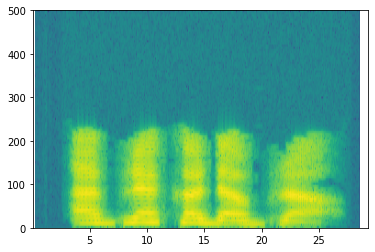

In [ ]:
np.seterr(divide = 'ignore') 
example_file = "./raw_data/Activates/Abracadabra-017.wav"
IPython.display.Audio(example_file)
S = graph_spectrogram(example_file, fs=1000)

Let's try with more specific sounds from the Animal Kingdom...

In [ ]:
examples = ['Cat.wav', 'Cow.wav', 'Dog.wav', 'Paper_Shredder.wav']

for example in examples:
  example = os.path.join('./audio_examples/', example)
  IPython.display.Audio(example)
  S = graph_spectrogram(example, fs=1000)

The graph above represents how active each frequency is (y axis) over a number of time-steps (x axis). 

<img src="https://github.com/fernandoGitHub/ML_Use_Cases/raw/main/Trigger_Word_Detection/notebook_images/spectrogram.png" style="width:500px;height:200px;">
<center> **Figure 1**: Spectrogram of an audio recording </center>


* The color in the spectrogram shows the degree to which different frequencies are present (loud) in the audio at different points in time. 
* Green means a certain frequency is more active or more present in the audio clip (louder).
* Blue squares denote less active frequencies.
* The dimension of the output spectrogram depends upon the hyperparameters of the spectrogram software and the length of the input. 
* In this notebook, we will be working with 10 second audio clips as the "standard length" for our training examples. 
    * The number of timesteps of the spectrogram will be 5511. 
    * You'll see later that the spectrogram will be the input $x$ into the network, and so $T_x = 5511$.

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (101, 5511)
Example of column values (101 values)
 [2.77067204e+02 7.69175263e+03 8.86157078e+02 1.47083167e+01
 2.04810007e+00 2.42805441e+00 3.24074775e-01 1.54015985e+00
 9.61003370e-01 2.57969084e-01 5.73035184e-02 3.24016102e-02
 2.72774805e-01 1.41928801e+00 1.21241281e+00 2.85154405e-01
 2.35511495e-01 9.76791714e-02 1.52657341e-01 9.80881356e-02
 1.19691463e-01 4.14215189e-01 2.72535031e-01 1.42180572e-01
 2.29917966e-02 4.83962404e-01 5.16216444e-01 2.68426294e-01
 8.17750893e-02 8.49729118e-02 3.71837779e-02 5.46089003e-02
 2.29870335e-02 5.17675764e-02 5.33965981e-02 1.32975148e-02
 7.18197992e-02 2.14768630e-02 1.88220531e-02 3.80332282e-02
 2.53519003e-02 4.89272727e-03 1.13993253e-02 2.55176041e-02
 2.25311747e-03 2.49274134e-02 3.19294942e-02 5.62689186e-03
 2.47565516e-03 6.15217092e-03 2.22972528e-02 3.86781100e-03
 1.78521873e-02 1.49090731e-03 1.65211165e-02 4.86616963e-0

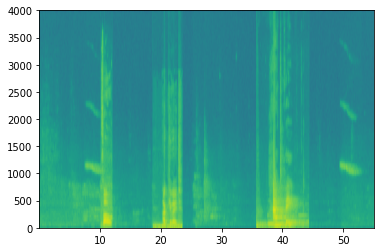

In [ ]:
example = "audio_examples/example_train.wav"
_, data = wavfile.read(example)
S = graph_spectrogram(example)
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", S.shape)
print(f"Example of column values (101 values)\n {S[:, 2000]}")

Let's define the audio input properties:

In [ ]:
Tx = 16536 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

### 3.2 - Division into time-intervals
* In the raw_audio files, the data is divided into 441,000 units (44.1K/s for 10 seconds).
* A spectrogram divides 30 seconds into 16,536 units.
    * $T_x = 16536$
* The output of our model will divide 30 seconds into 1,377 units.
    * $T_y = 1377$

In [ ]:
Ty = 1377 # The number of time steps in the output of our model

<a name='3-3'></a>
### 3.3 - Generating a Single Training Example

 

In [ ]:
# Load audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio('./raw_data/')

### 3.4 - Synthetizer functions

In [ ]:
def get_random_time_segment(segment_ms, low=0, high=30000):
  """
  Gets a random time segment of duration segment_ms in an audio clip.
  
  Arguments:
  segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
  
  Returns:
  segment_time -- a tuple of (segment_start, segment_end) in ms
  """
  segment_start = np.random.randint(low=low, high=high-segment_ms)   # Make sure segment doesn't run past the 10sec background 
  segment_end = segment_start + segment_ms - 1
  
  return (segment_start, segment_end)


def is_overlapping(segment_time, previous_segments):
  """
  Checks if the time of a segment overlaps with the times of existing segments.
  
  Arguments:
  segment_time -- a tuple of (segment_start, segment_end) for the new segment
  previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
  
  Returns:
  True if the time segment overlaps with any of the existing segments, False otherwise
  """
  segment_start, segment_end = segment_time
  overlap = False

  for previous_start, previous_end in previous_segments:
    if (segment_start <= previous_end) and (segment_end >= previous_start):
      overlap = True
      break

  return overlap


def insert_audio_clip(background, audio_clip, previous_segments):
  """
  Insert a new audio segment over the background noise at a random time step, ensuring that the 
  audio segment does not overlap with existing segments.
  
  Arguments:
  background -- a 30 second background audio recording.  
  audio_clip -- the audio clip to be inserted/overlaid. 
  previous_segments -- times where audio segments have already been placed
  
  Returns:
  new_background -- the updated background audio
  """
  segment_ms = len(audio_clip)
  segment_time = get_random_time_segment(segment_ms)
  
  retry = 25
  while is_overlapping(segment_time, previous_segments) and retry >= 0:
    segment_time = get_random_time_segment(segment_ms)
    retry = retry - 1

  if not is_overlapping(segment_time, previous_segments):
    previous_segments.append(segment_time)
    new_background = background.overlay(audio_clip, position = segment_time[0])
  else:
    new_background = background
    segment_time = (len(background), len(background))
  
  return new_background, segment_time

Let's test the Synthetizer Functions with 3 random examples

In [ ]:
for i in range(3):
  background = backgrounds[np.random.randint(0, len(backgrounds))]
  activate = activates[np.random.randint(0, len(activates))]
  segment = get_random_time_segment(len(activate), low=0, high=len(background))
  audio_clip, segment_time = insert_audio_clip(background, activate, [segment])
  output_file = "insert_test"+str(i)+".wav"
  audio_clip.export(output_file, format="wav")
  print("Segment Time: ", segment_time)
  IPython.display.Audio(output_file)

### 3.5 - Insert ones for the labels of the positive target

* Implement code to update the labels $y^{\langle t \rangle}$, assuming you just inserted an "activate" audio clip.
* In the code below, `y` is a `(1,1375)` dimensional vector, since $T_y = 1375$. 
* If the "activate" audio clip ends at time step $t$, then set $y^{\langle t+1 \rangle} = 1$ and also set the next 49 additional consecutive values to 1.

In [ ]:
def insert_ones(y, segment_end_ms, clip_duration=30000.0):
  """
  Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
  should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
  50 following labels should be ones.
  
  Arguments:
  y -- numpy array of shape (1, Ty), the labels of the training example
  segment_end_ms -- the end time of the segment in ms
  
  Returns:
  y -- updated labels
  """
  _, Ty = y.shape
  
  # Duration of the background (in terms of spectrogram time-steps)
  segment_end_y = int(segment_end_ms * Ty / clip_duration)
  
  if segment_end_y < Ty:
    for i in range(segment_end_y+1, segment_end_y+51):
      if i < Ty:
        y[0, i] = 1
  
  return y

### 3.6 - Creating a training example



In [ ]:
def create_training_example(output_file, background, activates, negatives, Ty, no_pos=8, no_neg=8):
  """
  Creates a training example with a given background, activates, and negatives.
  
  Arguments:
  background -- a 30 second background audio recording
  activates -- a list of audio segments of the word "activate"
  negatives -- a list of audio segments of random words that are not "activate"
  Ty -- The number of time steps in the output

  Returns:
  x -- the spectrogram of the training example
  y -- the label at each time step of the spectrogram
  """
  # Make background quieter
  background = background - 20
  y = np.zeros((1, Ty))
  previous_segments = []

  # Selecting Activates
  number_of_activates = np.random.randint(4, no_pos)
  random_indices = np.random.randint(len(activates), size=number_of_activates)
  random_activates = [activates[i] for i in random_indices]
  
  # Insert the activate audio clip on the background and setting the label to 1
  for random_activate in random_activates:
    background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
    previous_segments.append(segment_time)
    segment_start, segment_end = segment_time
    y = insert_ones(y, segment_end)

  # Selecting Negatives
  number_of_negatives = np.random.randint(4, no_neg)
  random_indices = np.random.randint(len(negatives), size=number_of_negatives)
  random_negatives = [negatives[i] for i in random_indices]

  # Insert the negative audio clip on the background 
  for random_negative in random_negatives:
    background, segment_time = insert_audio_clip(background, random_negative, previous_segments)
    previous_segments.append(segment_time)
  
  # Standardize the volume of the audio clip 
  background = match_target_amplitude(background, -20.0)

  # Export new training example 
  file_handle = background.export(output_file, format="wav")
  
  # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
  S = graph_spectrogram(output_file)
  
  return S, y

Now you can listen to the training example you created and compare it to the spectrogram generated above.

<_io.BufferedRandom name='/temp.wav'>

Time steps in audio recording before spectrogram (1323000,)
Time steps in input after spectrogram (101, 16536)


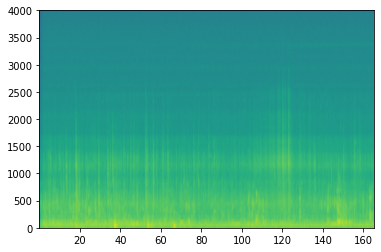

In [ ]:
backgrounds[0].export("/temp.wav", format="wav")

_, data = wavfile.read("/temp.wav")
S = graph_spectrogram("/temp.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", S.shape)


In [ ]:
output_file = 'training_sample.wav'
S, y = create_training_example(output_file=output_file, background=backgrounds[0], activates=activates, negatives=negatives, Ty=Ty)

IPython.display.Audio(output_file)

<a name='3-7'></a>
### 3.7 - Full Training Set

* You've now implemented the code needed to generate a single training example. 
* We used this process to generate a large training set. 
* To save time, we generate a smaller training set of 32 examples. 

  0%|          | 0/256 [00:00<?, ?it/s]

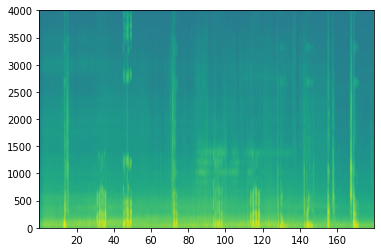

In [ ]:
nsamples = 256
S = []
Y = []
no_back = len(backgrounds)

for i in tqdm(range(nsamples)):
  back_index = np.random.randint(0, no_back)
  s, y = create_training_example(output_file='./synthetized_output/train_'+str(i).zfill(3)+'.wav', background=backgrounds[back_index], activates=activates, negatives=negatives, Ty=Ty)
  s = s[:,:16536]
  S.append(s.swapaxes(0,1))
  Y.append(y.swapaxes(0,1))
S = np.array(S)
Y = np.array(Y)

Saving the data for further use

In [ ]:
np.save(f'./XY_train/S.npy', S)
np.save(f'./XY_train/Y.npy', Y)
# Load the preprocessed training examples
# X = np.load("./XY_train/X.npy")
# Y = np.load("./XY_train/Y.npy")

<a name='4'></a>
## 4 - The Model

* The model will use 1-D convolutional layers, GRU layers, and dense layers. 


<img src="https://github.com/fernandoGitHub/ML_Use_Cases/raw/main/Trigger_Word_Detection/notebook_images/model.png" style="width:600px;height:600px;">



In [ ]:
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

In [ ]:
def modelf(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    X_input = Input(shape = input_shape)
    X = Conv1D(filters=196,kernel_size=15,strides=12)(X_input)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    X = Dropout(rate=0.95)(X)                                  

    X = GRU(units=128, return_sequences=True)(X)
    X = Dropout(rate=0.95)(X)
    X = BatchNormalization()(X)            
    
    X = GRU(units=128, return_sequences=True)(X)
    X = Dropout(rate=0.95)(X)
    X = BatchNormalization()(X)
    X = Dropout(rate=0.95)(X)               
    
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) 

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [ ]:
model = modelf(input_shape = (Tx, n_freq))

Let's print the model summary to keep track of the shapes.

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 16536, 101)]      0         
                                                                 
 conv1d_4 (Conv1D)           (None, 1377, 196)         297136    
                                                                 
 batch_normalization_12 (Bat  (None, 1377, 196)        784       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 1377, 196)         0         
                                                                 
 dropout_16 (Dropout)        (None, 1377, 196)         0         
                                                                 
 gru_8 (GRU)                 (None, 1377, 128)         125184    
                                                           

<a name='4.1'></a>
### 4.1 - Using a pre-trained model (for following iterations)

* Trigger word detection takes a long time to train. We trained it over 7000 epochs on a GPU.
* The following two cells can be used to load a pretrained version

In [ ]:
#from tensorflow.keras.models import model_from_json

#json_file = open('./models/model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#model = model_from_json(loaded_model_json)
#model.load_weights('./models/model.h5')

If you are going to fine-tune a pretrained model, it is important that you block the weights of all your batchnormalization layers. If you are going to train a new model from scratch, skip the next cell. 

In [ ]:
#model.layers[2].trainable = False
#model.layers[7].trainable = False
#model.layers[10].trainable = False

You can train the model further, using the Adam optimizer and binary cross entropy loss, as follows. This will run quickly because we are training just for two epochs and with a small training set of 32 examples. 

In [ ]:
opt = Adam(learning_rate=1e-6, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [ ]:
model.fit(S, Y, epochs=2500)

In [ ]:
model.save('./output_models/model_8000_epochs.h5', save_format='h5')

<a name='5'></a>
## 5 - Making Predictions

In [ ]:
def detect_triggerword(filename, y=None):
  plt.subplot(3, 1, 1)
  
  # Correct the amplitude of the input file before prediction 
  audio_clip = AudioSegment.from_wav(filename)
  audio_clip = match_target_amplitude(audio_clip, -20.0)
  file_handle = audio_clip.export("tmp.wav", format="wav")
  filename = "tmp.wav"

  x = graph_spectrogram(filename)
  x = x[:,:16536]
  # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
  x  = x.swapaxes(0,1)
  x = np.expand_dims(x, axis=0)
  predictions = model.predict(x)
  
  plt.subplot(3, 1, 2)
  plt.plot(predictions[0,:,0])
  plt.ylabel('Probability')

  if type(y) != type(None):
    plt.subplot(3, 1, 3)
    plt.plot(y)
    plt.ylabel('Labelling')

  plt.show()
  return predictions

In [ ]:
chime_file = "audio_examples/chime.wav"
def chime_on_activate(filename, predictions, threshold):
  audio_clip = AudioSegment.from_wav(filename)
  chime = AudioSegment.from_wav(chime_file)
  Ty = predictions.shape[1]
  # Step 1: Initialize the number of consecutive output steps to 0
  consecutive_timesteps = 0
  # Step 2: Loop over the output steps in the y
  for i in range(Ty):
    # Step 3: Increment consecutive output steps
    consecutive_timesteps += 1
    # Step 4: If prediction is higher than the threshold and more than 20 consecutive output steps have passed
    if consecutive_timesteps > 20:
      # Step 5: Superpose audio and background using pydub
      audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds) * 1000)
      # Step 6: Reset consecutive output steps to 0
      consecutive_timesteps = 0
    # if amplitude is smaller than the threshold reset the consecutive_timesteps counter
    if predictions[0, i, 0] < threshold:
      consecutive_timesteps = 0
      
  audio_clip.export("chime_output.wav", format='wav')

<a name='5-1'></a>
### 5.1 - Test on Train Examples
We haven't prepared a dev set so let's try this on some of the training examples

./synthetized_output/train_021.wav


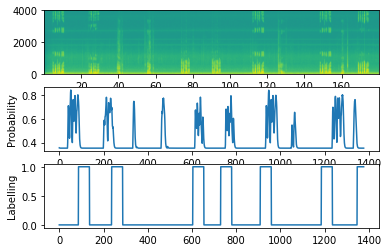

./synthetized_output/train_207.wav


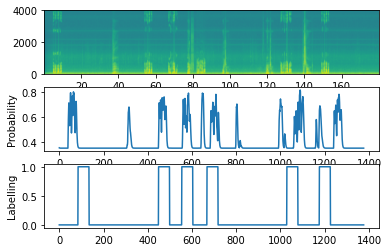

./synthetized_output/train_221.wav


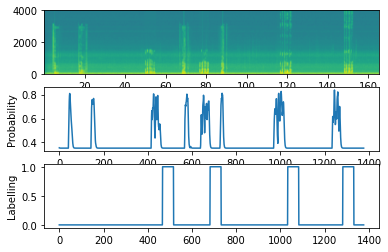

In [ ]:
for i in range(3):
  index = np.random.randint(256)
  filename = f'./synthetized_output/train_{str(index).zfill(3)}.wav'
  print(filename)
  prediction = detect_triggerword(filename, y=Y[index,:,:])
  chime_on_activate(filename, prediction, 0.42)
  # Uncomment to hear the results (commented for Github)
  #IPython.display.Audio("./chime_output.wav")

## 6 - Final Thoughts

The model managed to train fairly well given the small number of examples. It is not perfect but it really amazes every time it manages to get a prediction right. Amazing stuff! :-)